In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf_yw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy.fftpack import fft


C:\Users\Justin\AppData\Local\Temp\ipykernel_27544\2347327822.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


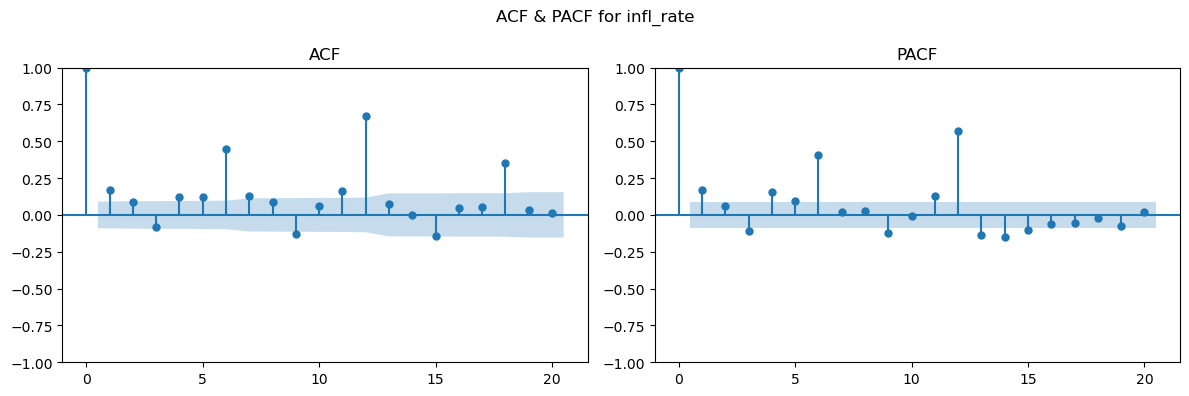

infl_rate: p-value = 0.02133416177384412


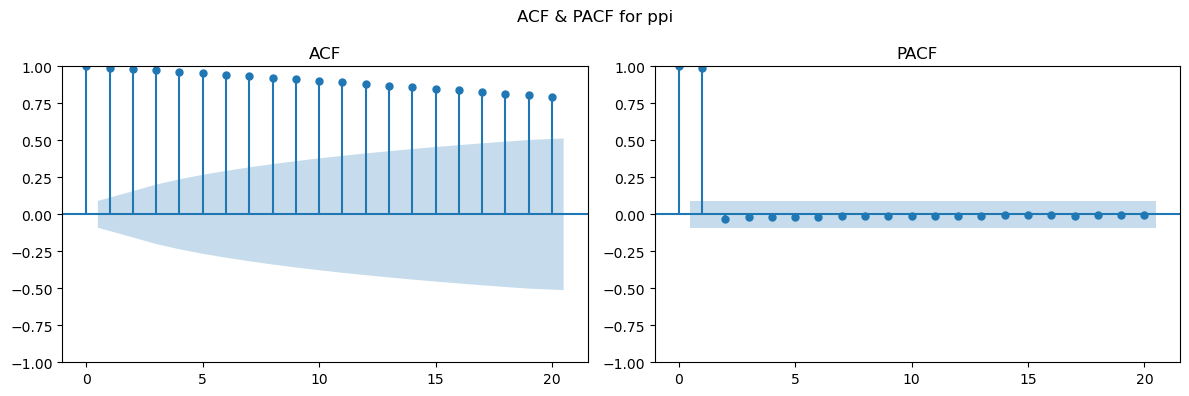

ppi: p-value = 0.978908346428475
Non-stationary ppi differenced for stationarity


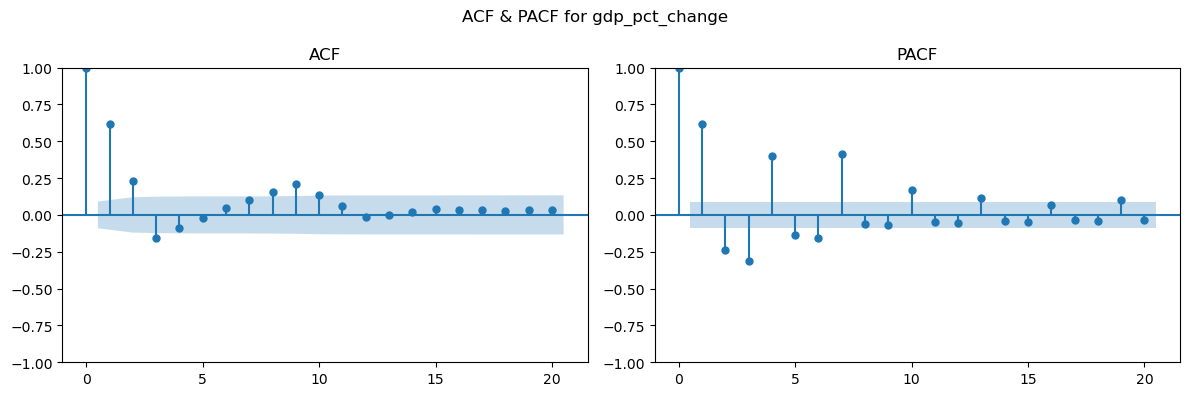

gdp_pct_change: p-value = 0.00039413535611770926


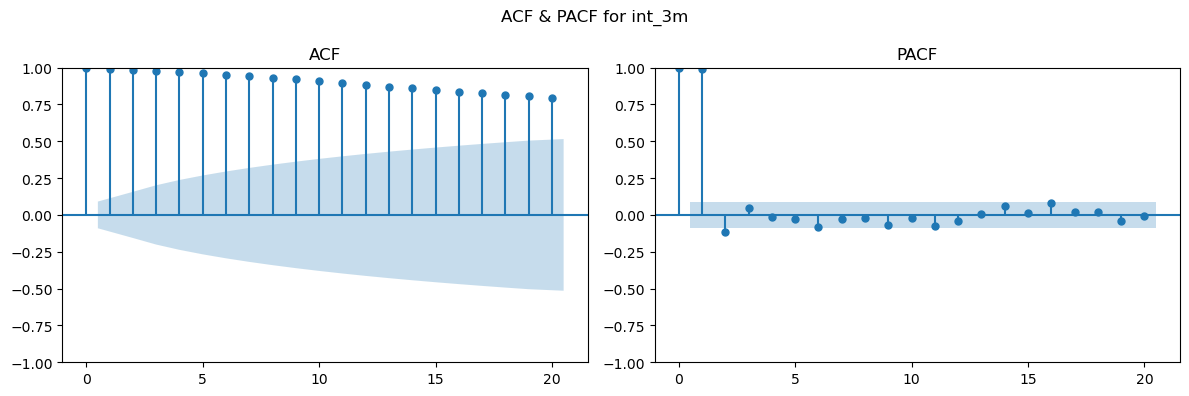

int_3m: p-value = 0.49733890398549624
Non-stationary int_3m differenced for stationarity


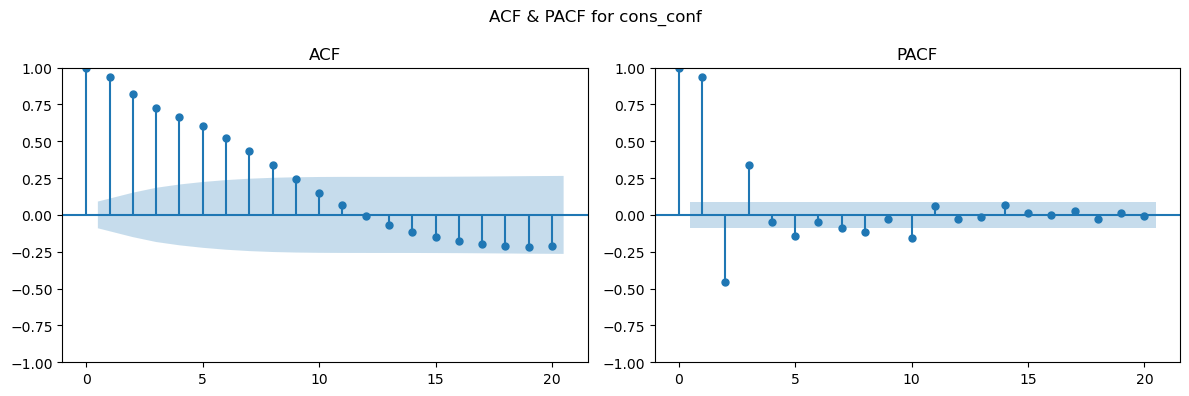

cons_conf: p-value = 1.6534059253850702e-08


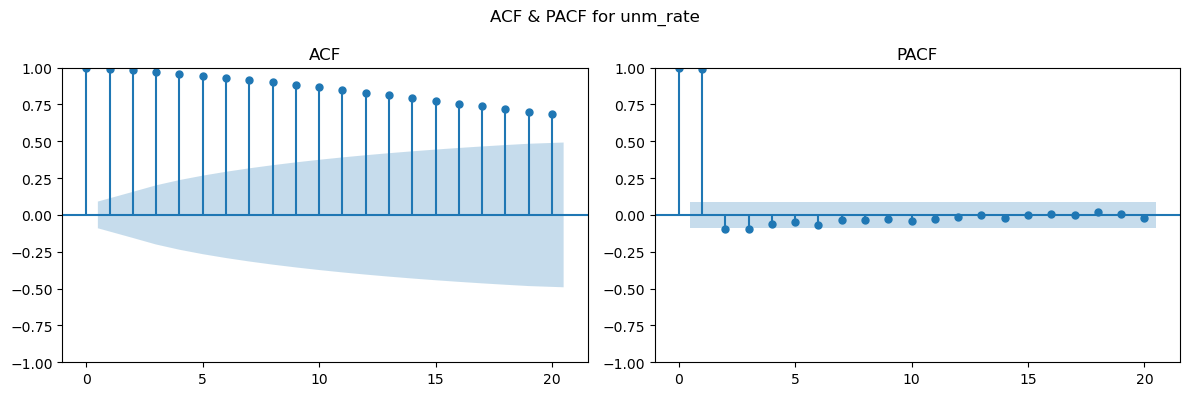

unm_rate: p-value = 0.07077782574137147
Non-stationary unm_rate differenced for stationarity
Variables that need differencing: ['ppi', 'int_3m', 'unm_rate']


In [ ]:
def preprocess_data(df):
    """
    Clean and preprocess the DataFrame:
      - Convert 'date' column to datetime and set as index.
      - Interpolate missing values.
      - Identify outliers in CPI using the Z-score method.
      - Check stationarity of the series using the ADF test and plot the PACF.
      - Identify and visualize seasonal decomposition of each series.
      - Perform Ljung-Box test on residuals to check for any remaining autocorrelation.
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        df (DataFrame): Preprocessed DataFrame with new columns added.
    """
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    # Handle missing values using forward fill for simplicity in this example
    df.fillna(method='ffill', inplace=True)
    need_differencing = []

    # Plot PACF for each macroeconomic variable including CPI
    variables = ['infl_rate', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']
    for var in variables:
        if var in df.columns:
            # Create side-by-side subplots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f'ACF & PACF for {var}')

            # ACF plot
            plot_acf(df[var].dropna(), lags=20, ax=axes[0])
            axes[0].set_title('ACF')

            # PACF plot
            plot_pacf(df[var].dropna(), lags=20, method='ywm', ax=axes[1])
            axes[1].set_title('PACF')

            plt.tight_layout()
            plt.show()

            # Check for stationarity and differencing
            result = adfuller(df[var])
            print(f'{var}: p-value = {result[1]}')
            if result[1] > 0.05:  # if p-value > 0.05, series is not stationary
                need_differencing.append(var)
                df[f'{var}_diff'] = df[var].diff().dropna()
                print(f'Non-stationary {var} differenced for stationarity')
    # Print those that need differencing
    print(f"Variables that need differencing: {need_differencing}")

    return df

df = pd.read_csv('../data/UK_consolidated_df.csv')
df_preprocessed = preprocess_data(df)


In [12]:
df

,infl_rate,ppi,gdp_pct_change,int_3m,cons_conf,unm_rate,ppi_diff,int_3m_diff,unm_rate_diff
date,,,,,,,,,
1986-02-01,0.004158,51.456058,1.789575,12.71875,99.70575,11.1,NaN,NaN,NaN
1986-03-01,0.001035,51.456058,1.789575,11.77679,99.74067,11.2,0.000000,-0.94196,0.1
1986-04-01,0.010341,51.612699,1.219277,10.57670,99.80801,11.3,0.156641,-1.20009,0.1
1986-05-01,0.001024,51.377741,1.219277,10.26705,99.85727,11.3,-0.234958,-0.30965,0.0
1986-06-01,0.000000,51.456058,1.219277,9.82292,99.89935,11.3,0.078317,-0.44413,0.0
...,...,...,...,...,...,...,...,...,...
2024-08-01,0.003762,136.488626,1.364935,4.91000,101.52670,4.3,0.000000,-0.18000,0.2
2024-09-01,0.000750,136.488626,1.364935,4.84000,101.45370,4.3,0.000000,-0.07000,0.0
2024-10-01,0.005993,136.488626,1.064721,4.75000,101.33200,4.4,0.000000,-0.09000,0.1


EDA

Index(['date', 'infl_rate', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf',
       'unm_rate'],
      dtype='object')
int_3m
unm_rate


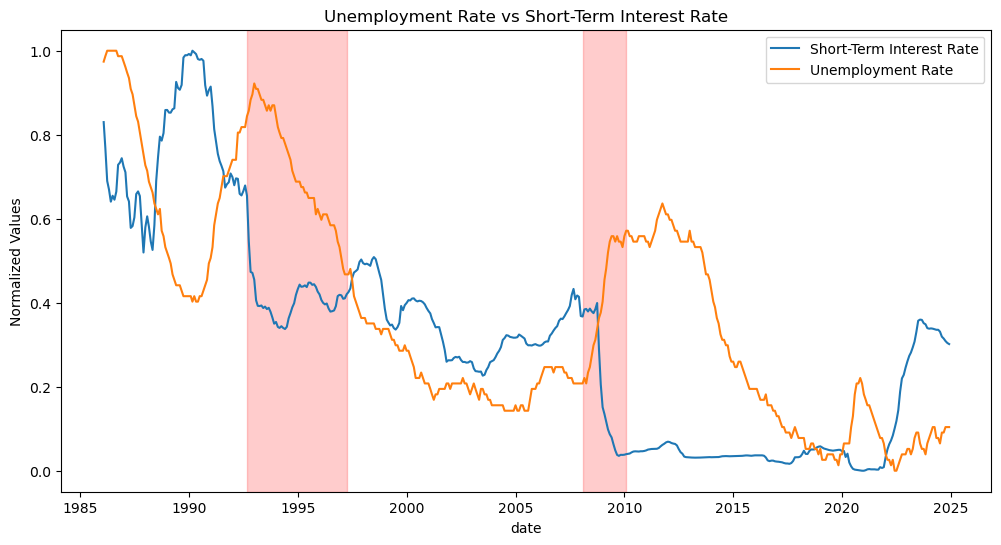

cons_conf
gdp_pct_change


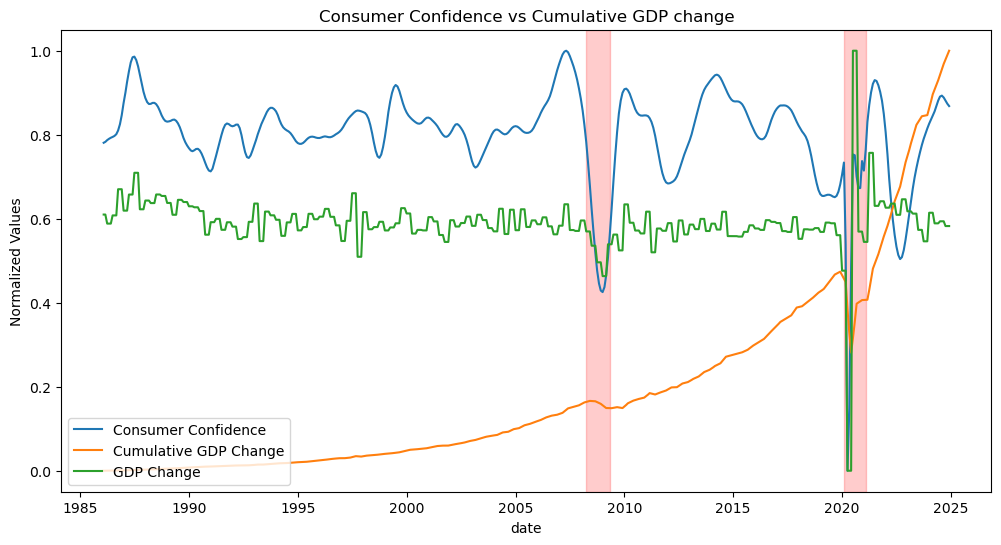

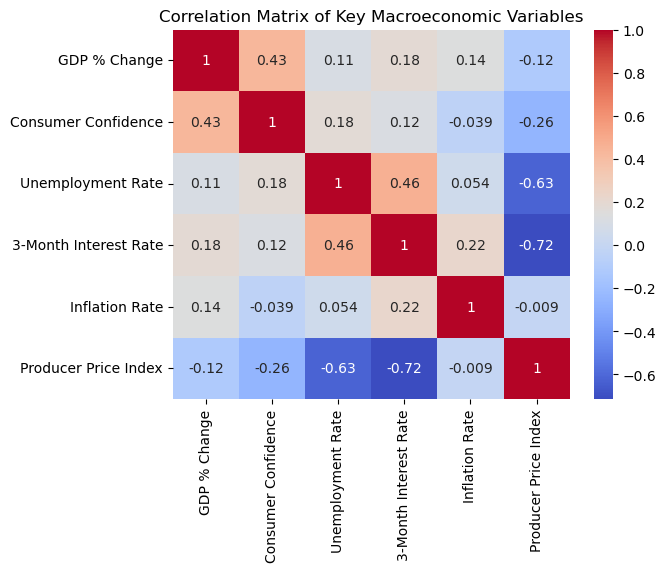

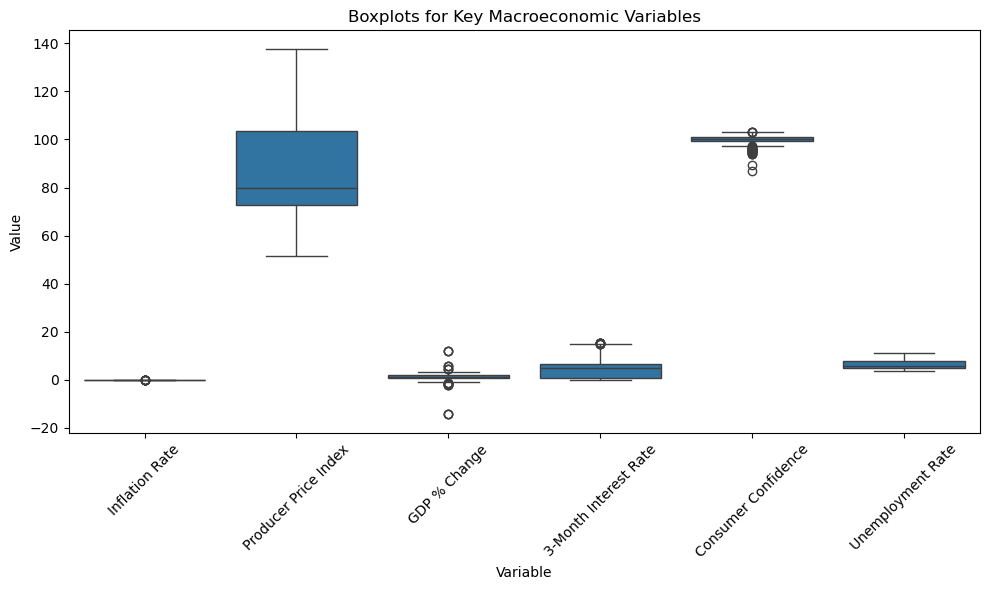

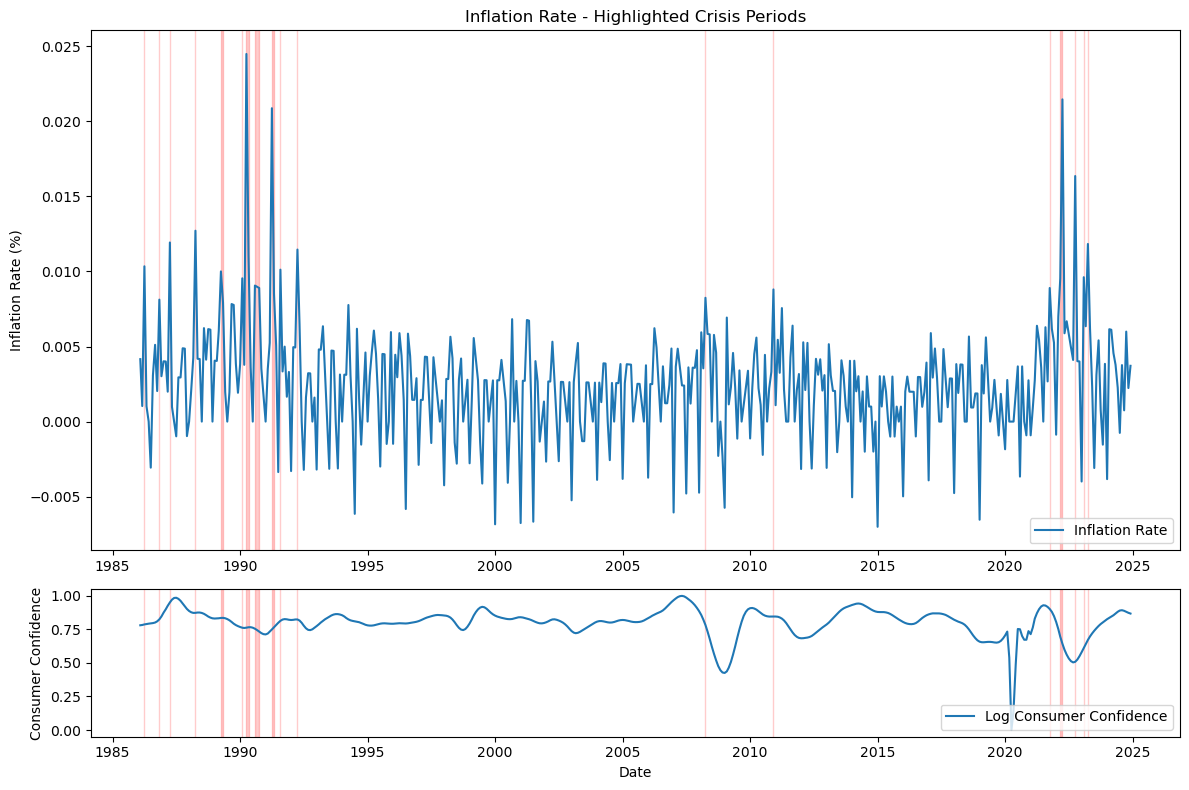

In [89]:
from scipy.cluster.hierarchy import linkage, leaves_list
from itertools import groupby
from operator import itemgetter
from matplotlib.gridspec import GridSpec
import numpy as np

def exploratory_data_analysis(df):
    """
    Perform enhanced Exploratory Data Analysis (EDA):
    - Analyze inflation rate trends.
    - Check for correlation with other macroeconomic variables.
    - Identify and visualize major economic events.
    - Detect potential crises based on inflation rate spikes.
    - Perform FFT to identify cyclical patterns.
    - Compare inflation rates across different datasets/countries if applicable.
    """
    df['date'] = pd.to_datetime(df['date'])
    df_plot = df.reset_index()

    # 1. Plot time series (unemployment rate vs short term interest rate)
    first_plot_custom_labels = {
    'unm_rate': 'Unemployment Rate',
    'int_3m': 'Short-Term Interest Rate'
    }
    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())
    
    indicators = ['int_3m', 'unm_rate']
    plt.figure(figsize=(12, 6))
    for indicator in indicators:
        if indicator in df_plot.columns:
            print(indicator)
            normalized_series = min_max_scaling(df_plot[indicator])
            plt.plot(df_plot['date'], normalized_series, label=first_plot_custom_labels[indicator])
    # Highlight the two date ranges
    highlight_ranges = [
        ('1992-09-01', '1997-04-01'),
        ('2008-02-01', '2010-02-01')
    ]
    for start, end in highlight_ranges:
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)
    plt.title('Unemployment Rate vs Short-Term Interest Rate')
    plt.xlabel('date')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()

    # 1. Plot time series (consumer confidence vs cumulative GDP change)

    second_plot_custom_labels = {
    'cons_conf': 'Consumer Confidence',
    'gdp_pct_change': 'GDP Change'
    }
    indicators = ['cons_conf', 'gdp_pct_change']
    plt.figure(figsize=(12, 6))

    for indicator in indicators:
        if indicator in df_plot.columns:
            print(indicator)
            if indicator == 'gdp_pct_change':
                # Convert percentage change to cumulative change
                cumulative_gdp = (1 + df_plot[indicator] / 100).cumprod()
                normalized_cumu_series = min_max_scaling(cumulative_gdp)
                plt.plot(df_plot['date'], normalized_cumu_series, label="Cumulative GDP Change")
            normalized_series = min_max_scaling(df_plot[indicator])
            plt.plot(df_plot['date'], normalized_series, label=second_plot_custom_labels[indicator])
    highlight_ranges = [
        ('2008-04-01', '2009-05-01'),
        ('2020-02-01', '2021-02-01')
    ]
    for start, end in highlight_ranges:
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)

    plt.title('Consumer Confidence vs Cumulative GDP change')
    plt.xlabel('date')
    plt.ylabel('Normalized Values')
    plt.legend(loc='lower left')
    plt.show()


    # 2. Correlation heatmap for key macroeconomic variables
    third_and_fourth_plot_custom_labels = {
    'infl_rate': 'Inflation Rate',
    'ppi': 'Producer Price Index',
    'gdp_pct_change': 'GDP % Change',
    'int_3m': '3-Month Interest Rate',
    'cons_conf': 'Consumer Confidence',
    'unm_rate': 'Unemployment Rate'
    }

    manual_order = ['gdp_pct_change','cons_conf', 'unm_rate', 'int_3m', 'infl_rate', 'ppi']

    key_variables = list(third_and_fourth_plot_custom_labels.keys())
    corr_matrix = df[key_variables].corr()
    sorted_corr = corr_matrix.loc[manual_order, manual_order]
    sorted_corr.rename(index=third_and_fourth_plot_custom_labels, columns=third_and_fourth_plot_custom_labels, inplace=True)
    sns.heatmap(sorted_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Key Macroeconomic Variables')
    plt.show()

    # 5. Boxplot for Outlier Detection
    # Melt the DataFrame into long format
    df_melted = df[key_variables].melt(var_name='Variable', value_name='Value')
    df_melted['Variable'] = df_melted['Variable'].map(third_and_fourth_plot_custom_labels)

    # Create vertical boxplots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplots for Key Macroeconomic Variables')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. Crisis Detection - High Inflation Periods
    # Identify high inflation threshold and spans
    crisis_threshold = df['infl_rate'].quantile(0.95)
    df['High Inflation'] = df['infl_rate'] > crisis_threshold

    # Get index groups for consecutive high inflation periods
    high_inflation_indices = df[df['High Inflation']].index.tolist()
    groups = []
    for k, g in groupby(enumerate(high_inflation_indices), lambda ix: ix[0] - ix[1]):
        group = list(map(itemgetter(1), g))
        groups.append((df['date'].iloc[group[0]], df['date'].iloc[group[-1]]))

    # Set up plot grid: 3/4 height for inflation, 1/4 for consumer confidence
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(4, 1, figure=fig)

    # --- Top plot: Inflation Rate (3 rows) ---
    ax1 = fig.add_subplot(gs[:3, 0])
    ax1.plot(df['date'], df['infl_rate'], label='Inflation Rate')

    for start_date, end_date in groups:
        ax1.axvspan(start_date, end_date, color='red', alpha=0.2)

    ax1.set_title('Inflation Rate - Highlighted Crisis Periods')
    ax1.set_ylabel('Inflation Rate (%)')
    ax1.legend(loc='lower right')

    # --- Bottom plot: Consumer Confidence (1 row) ---
    ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax2.plot(df['date'], min_max_scaling(df_plot['cons_conf']), label='Log Consumer Confidence', color='tab:blue') 

    for start_date, end_date in groups:
        ax2.axvspan(start_date, end_date, color='red', alpha=0.2)

    ax2.set_ylabel('Consumer Confidence')
    ax2.set_xlabel('Date')
    ax2.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    return df

df = pd.read_csv('../data/UK_consolidated_df.csv')
print(df.columns)  # This line will print the DataFrame columns for debugging
eda_results = exploratory_data_analysis(df)